In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Load the MNIST dataset, split between train and test and scale. 

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scale the training and testing data so that they are in a range between 0 and 1
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
x_test = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Assign approriate values for the variables. 

In [3]:
batch_size = 50
input_dim = 784 # Pixel values 28*28
latent_dim = 2
hidden_dim = 256 # Required to be smaller than the input
epochs = 20
epsilon_std = 1.0

Define the encoder, mean and standard deviation of the latent variables.

In [4]:
x = Input(shape=(input_dim,))
# Encoder
h = Dense(hidden_dim, activation='relu')(x)

# Mean of the latent variables
z_mean = Dense(latent_dim)(h)

# Standard deviation of latent variables
z_log_var = Dense(latent_dim)(h)

Define a function that will sample from the latent space. 

In [5]:
def sampling_function(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

Define z to be a random sample from the latent normal distribution. 

In [6]:
z = Lambda(sampling_function, output_shape=(latent_dim,))([z_mean, z_log_var])

Assign the three layers for the decoder; we map the sampled points from the latent space. 

In [7]:
decoder = Dense(hidden_dim, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')
h_decoded = decoder(z)
x_decoded_mean = decoder_mean(h_decoded)

Now instantiate the VAE model. 

In [8]:
vae = Model(x, x_decoded_mean)

Compute the loss for the VAE.

In [9]:
xent_loss = input_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

Compile and fit the model. 

In [10]:
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

Here we build a model in order to project the inputs onto the latent space. 

In [11]:
encoder = Model(x, z_mean)

We can plot the digit classes in the latent space. 

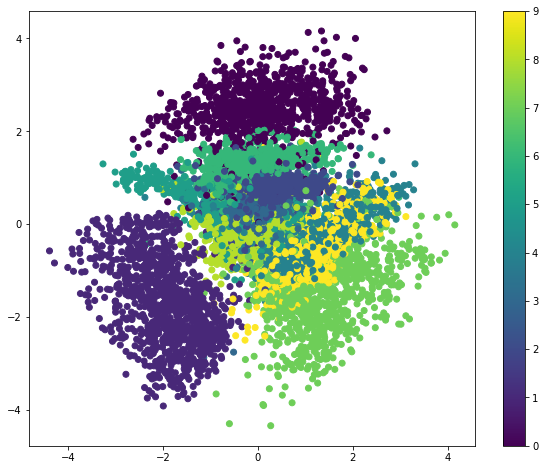

In [12]:
x_test_e = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(10, 8))
plt.scatter(x_test_e[:, 0], x_test_e[:, 1], c=y_test)
plt.colorbar()
plt.show()

Now we build a digit generator that can sample from the learned distribution. 

In [13]:
input_decoder = Input(shape=(latent_dim,))
_h_decoded = decoder(input_decoder)
_x_decoded_mean = decoder_mean(_h_decoded)
gen = Model(input_decoder, _x_decoded_mean)

In order to display a manifold of the digits we can run the below. 

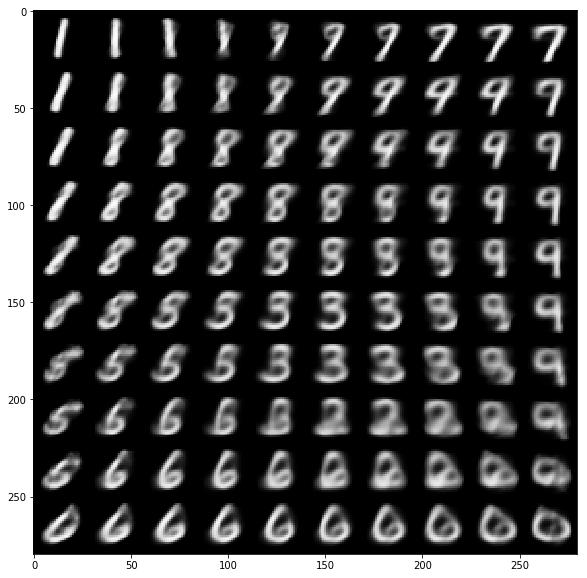

In [14]:
n = 10  
size_digit = 28
figure = np.zeros((size_digit * n, size_digit * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = gen.predict(z_sample)
        digit = x_decoded[0].reshape(size_digit, size_digit)
        figure[i * size_digit: (i + 1) * size_digit,
               j * size_digit: (j + 1) * size_digit] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()